In [8]:
import igl
import scipy
import numpy as np
from meshplot import plot, subplot, interact
import os
from scipy.sparse import csr_matrix
from pygsp.graphs import Graph
from scipy.spatial import ConvexHull

root_folder = os.path.join(os.getcwd(), "ghcn_data")
root_folder

'/Users/Mart/Documents/EPFL/transphere/martino/ghcn_data'

In [5]:
class cotan(Graph):

    def __init__(self, coords):
        self.coords = coords
        self.tri = ConvexHull(self.coords).simplices
        self.npix = np.alen(self.coords)
        W = csr_matrix((self.npix, self.npix), dtype=np.float32)
        self.cotan = igl.cotmatrix(self.coords, self.tri)
        self.mass = igl.massmatrix(self.coords, self.tri, igl.MASSMATRIX_TYPE_BARYCENTRIC)
        W = scipy.sparse.diags(1/self.mass.diagonal()) @ self.cotan
        W.setdiag(0, 0)
        super(cotan, self).__init__(W, coords=self.coords)
    
    def e(self, N=5):  # how many eigenvectors do I calculate
        self.eig_values, self.eig_vectors = scipy.sparse.linalg.eigsh(-self.cotan, k=16, M=self.mass, sigma=0.001)
    
    def plot_e(self, N=1):
        plot(self.coords, self.tri, self.eig_vectors[:,N])
    

In [6]:
nstations = 500
stations = np.load('ghcn_data/ghcn_stations_2010-2014.npz')
data = np.load('ghcn_data/ghcn_data_2010-2014_TMAX.npz')

keep = data['valid_days'].flatten()
data = data['data'].reshape(len(stations['id_ghcn']), -1)
data = data[:, keep]
data = data / 10

# Show the same stations as for the temperature plot.
year, month, day = 2014, 1, 1
t = (year-2010)*365 + (month-1)*30 + (day-1)
keep = ~np.isnan(data[:, t])

data = data[keep]
lon = stations['lon'][keep]
lat = stations['lat'][keep]

print('n_stations: {}, n_days: {}'.format(nstations, data.shape[1]))

# Rotate the view.
lon -= 50
lat -= 20

lon *= np.pi / 180
lat *= np.pi / 180

x = np.cos(lat) * np.cos(lon)
y = np.cos(lat) * np.sin(lon)
z = np.sin(lat)

coords = np.stack([x, y, z], axis=1)
coords = coords[np.random.permutation(np.alen(coords))][:nstations]

n_stations: 500, n_days: 1826


In [9]:
sphere = cotan(coords)

In [10]:
sphere.e()

In [11]:
sphere.plot_e(1)

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(0.0158111…

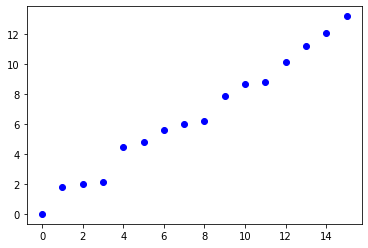

In [12]:
import matplotlib.pyplot as plt
plt.plot(sphere.eig_values, 'bo')